# Computational Modeling of Face Acts in Persuasion Oriented Discussions

**Description:** The notion of face refers to the public self-
image of an individual that emerges both from the individual’s own actions as well as from the interaction with others. Modeling face and understanding its state changes throughout a conversation is critical to the study of maintenance of basic human needs in and through interaction.

we propose a generalized framework for modeling face acts in persuasion conversations, resulting in a reliable coding manual, an annotated corpus, and
computational models. The framework reveals insights about differences in face act utilization between asymmetric roles in persuasion conversations. Using computational models,we are trying to identify face acts as well as predict a key conversational outcome(e.g. donation success).


* Working with DeBERTa - Known for high performance on various NLP benchmarks, DeBERTa uses disentangled attention and enhanced representations. It's effective for more nuanced intent detection tasks.


# Data Description
We use the pre-existing persuasion corpus of Wang et al. (2019). Each conversation comprises a series of exchanges where the persuader (ER) has to
convince the persuadee (EE) to donate a part of their task earnings to the charity, Save the Children.This selected corpus is well-situated for our task
since each conversation is guaranteed to have a potential face threat (i.e., a request for money) and hence, we can expect face act exchanges between
the two participants.

In a two-party conversation, a face act can either raise (+) or attack (-) the positive face (Pos) or negative face (Neg) of either the speaker (S) or the hearer (H), leading to 8 possible different outcomes. For example, HPos+ means raising the positive face of the hearer. We provide a generalized framework below for labelling a speech act / utterance with one or more face acts, building upon the politeness theory of Brown and Levinson
(1978).The framework is designed to be explicit enough to ensure the creation of a reliable coding manual for classifying face-acts, as opposed to the simple classification of requests and other directives as intrinsic FTAs (Brown and Levinson,1978). Moreover, since we also seek to operationalize FSA, we make some departure from the original classification of directives. For example, we feel that compliments directed at the hearer, should be HPos+ rather than HNeg- (as observed in Brown et al. (1987)) since an appreciation for someone’s
efforts is more desirable.

| Face Act  | Description |
|-----------|-------------|
| **SPos+ (i)**  | S posit that they are virtuous in some aspects or they are good. |
| **SPos+ (ii)** | S compliment the brand or item they represent or endorse and thus project their credibility. |
| **SPos+ (iii)** | S state their preference or want, something that they like or value. |
| **SPos- (i)** | S confess or apologize for being unable to do something that is expected of them. |
| **SPos- (ii)** | S criticize or humiliate themselves. They damage their reputation or values by either saying they are not so virtuous or criticize some aspect of the brand/item they endorse or support. |
| **HPos+ (i)** | S compliment H either for H’s virtues, efforts, likes or desires. It also extends to S acknowledging the efforts of H and showing support for H. |
| **HPos+ (ii)** | S can also provide an implicit compliment to incentivize H to do something good. |
| **HPos+ (iii)** | S empathize / sympathize or in general agree with H. |
| **HPos+ (iv)** | S is willing to do the FTA as imposed by H (implying that the FTA is agreeable to S). |
| **HPos- (i)** | S voice doubts or criticize H or the product/brand that H endorses. |
| **HPos- (ii)** | S disagree with H over some stance, basically contradicting their viewpoint. |
| **HPos- (iii)** | S is either unaware or indifferent to H’s wants or preferences. |
| **SNeg+ (i)** | S reject or are unwilling to do the FTA. Stating the reason does not change the circumstances of non-compliance but sometimes helps to mitigate the face act. |
| **SNeg- (i)** | S offer to assist H. |
| **HNeg+ (i)** | S seek to decrease the imposition of the FTA on H by either decreasing the inconvenience such as providing alternate, simpler ways to carry out the FTA or decrease the threat associated with the FTA. |
| **HNeg+ (ii)** | S apologize for the FTA to show that S understood the inconvenience of imposing the request but they have to request nevertheless. |
| **HNeg- (i)** | S impose an FTA on the H. The FTA is some act which H would not have done on their own. |
| **HNeg- (ii)** | S increase the threat or ranking of the FTA. |
| **HNeg- (iii)** | S ask/request H for assistance. |


### 1. Setup

Lets get all our libraries and download and process our data.

In [4]:
!pip install transformers>=4.41.0,<5.0.0 --upgrade

/bin/bash: line 1: 5.0.0: No such file or directory


In [5]:
#Download Keras 2 versions of software
!pip install tensorflow==2.15.0 --quiet
!pip install tf-keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet
!pip install ml-dtypes>=0.3.1 --quiet

In [8]:
!pip install pyarrow==17.0.0  # Compatible with cudf-cu12 and pylibcudf-cu12
!pip install fsspec==2024.10.0  # Required by gcsfs
!pip install transformers==4.41.0  # Compatible with sentence-transformers

In [9]:
!pip install pydot

In [10]:
!pip install -U scikit-learn

In [11]:
from sklearn.metrics import classification_report

In [12]:
from datasets import load_dataset

In [13]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from datasets import Dataset
from sklearn.utils import shuffle

import seaborn as sns
import re
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification

In [14]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from transformers import TFDebertaV2ForSequenceClassification
from sklearn.utils import class_weight

We're going to use the 20 newsgroups dataset as it is ideal for exploring multiclass classification.  It includes posts from 20 different newsgroups.  Our task will be to correctly label a post with it's group.  We'll download a version available from Hugging Face.

### 2. Load the Dataset

In [15]:
# GitHub raw URL
url = 'https://raw.githubusercontent.com/ShoRit/face-acts/master/data/Persuasion%20Face%20Act%20Prediction.xlsx'

# Load the Excel file
ds = pd.read_excel(url, engine='openpyxl')

# Step 2: Select the desired columns
ds = ds[['conversation_id', 'speaker', 'utterance', 'true_face']]

# Map speaker values to labels using .loc to avoid SettingWithCopyWarning
ds.loc[:, 'speaker'] = ds['speaker'].map({0: 'ER', 1: 'EE'})


# Display the new DataFrame with selected columns
print(ds.head(5))



   conversation_id speaker                                          utterance  \
0              120      ER                                                Hi!   
1              120      ER  Have you heard of an organization called Save ...   
2              120      EE  I think I have once before, in a grocery store...   
3              120      ER  Do you mind if i give you a little information...   
4              120      EE                                     Sure, go ahead   

  true_face  
0     other  
1     other  
2     hpos+  
3     hneg-  
4     hpos+  


<ipython-input-15-9c328697f2d7>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['ER' 'ER' 'EE' ... 'EE' 'ER' 'EE']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ds.loc[:, 'speaker'] = ds['speaker'].map({0: 'ER', 1: 'EE'})


Take a look at the records.  We basically have a Conversation_id, speaker with binary values of 0 and 1 representing a EE and ER , Persuadee and persuader for "Save the Children" charity donation. Utterence by the EE/ER and the true_face which we will use in the model for multi-classification into the above 7 classes.

Take a look at the sample record:
* Identifier: Unique identifier for the conversation.

* Speaker: The speaker refers to the individual delivering the utterance, which can be a participant in the conversation, such as ER or EE. ER acts as the Persuader, attempting to convince EE, the Persuadee, to contribute to the charity program "Save the Children."

* Utterance: The spoken or written statement made by the speaker. This reflects their thoughts, feelings, or intentions.

* True Face: A classification that captures the underlying intent or emotional state of the speaker. It may indicate positive or negative aspects of their communication, categorized into different labels (e.g., HPos+, HPos-, SPos+, SPos-).


## 2.1 Identify unique speaker and true_face values in the dataset


In [16]:
# Initialize a dictionary to store unique true_faces for each speaker
speaker_true_faces = defaultdict(set)

# Iterate through the DataFrame to collect unique true_faces for each speaker
for index, row in ds.iterrows():  # Using iterrows() to get each row
    speaker = row['speaker']
    true_face = row['true_face']

    # Add the true_face to the set for the corresponding speaker
    speaker_true_faces[speaker].add(true_face)

# Convert the sets to lists for better readability
speaker_true_faces = {speaker: list(true_faces) for speaker, true_faces in speaker_true_faces.items()}

# Create a DataFrame to view unique speakers and their unique true_faces
unique_speakers_df = pd.DataFrame({
    'Speaker': speaker_true_faces.keys(),
    'Unique True Faces': [true_faces for true_faces in speaker_true_faces.values()]
})

# Display the DataFrame
print(unique_speakers_df)

  Speaker                                  Unique True Faces
0      ER         [hpos-, hneg-, hpos+, other, spos+, hneg+]
1      EE  [hpos-, sneg+, spos-, hneg-, hpos+, other, spos+]


## Observations

* ER lacks the spos- expression, which is indeed significant. Since ER represents the charity, it is logical that they wouldn’t express negative sentiments towards the organization they are promoting. Criticism would be counterproductive in a persuasive context where the goal is to encourage the EE to donate.

* Diversity in Expression: This difference may indicate that EE is capable of conveying a greater variety of emotional states including criticism towards charity.

* Model Training: If we are using this data, having more unique expressions for one speaker could affect how a model learns to recognize and classify emotions, possibly leading to more robust outcomes for EE.

* Next Steps : Modelling the BERT model for ER and EE separately as EE has one additional emotional variance as compared to EE.


### 2.2 Split the dataset into ER and EE datasets

In [17]:
# Split the DataFrame into ER and EE datasets
ER_dataset = ds[ds['speaker'] == 'ER']
EE_dataset = ds[ds['speaker'] == 'EE']

# Display the first 5 rows of each dataset
print("ER Dataset:")
print(ER_dataset.head(5))

print("\nEE Dataset:")
print(EE_dataset.head(5))

ER Dataset:
   conversation_id speaker                                          utterance  \
0              120      ER                                                Hi!   
1              120      ER  Have you heard of an organization called Save ...   
3              120      ER  Do you mind if i give you a little information...   
5              120      ER  Just some ver basic info, Save the Children is...   
7              120      ER                                      Yes they are!   

  true_face  
0     other  
1     other  
3     hneg-  
5     spos+  
7     other  

EE Dataset:
    conversation_id speaker  \
2               120      EE   
4               120      EE   
6               120      EE   
13              120      EE   
14              120      EE   

                                            utterance true_face  
2   I think I have once before, in a grocery store...     hpos+  
4                                      Sure, go ahead     hpos+  
6                 A

## 2.2 Format the ER dataset to train the model

In [18]:
# Function to clean dialogue
def clean_dialogue(dialogue):
    if isinstance(dialogue, str):  # Ensure the input is a string
        # Lowercase
        dialogue = dialogue.lower()
        # Remove punctuation
        dialogue = re.sub(r'[^\w\s]', '', dialogue)
        # Strip whitespace
        dialogue = dialogue.strip()
        return dialogue
    else:
        return ""  # Return an empty string or handle as you prefer

cleaned_data = []
ER_formatted_ds = []
true_face_labels = set()  # To collect unique true_face labels

# Use iterrows() to iterate through the DataFrame
for index, row in ER_dataset.iterrows():
    speaker = row['speaker']
    utterance = row['utterance']
    true_face = row['true_face']

    # Clean the utterance
    cleaned_utterance = clean_dialogue(utterance)

    # Collect unique true_face labels
    true_face_labels.add(true_face)

    # Append the speaker and cleaned utterance to the formatted data
    ER_formatted_ds.append({
        'speaker': f"{speaker}",
        'dialogue': cleaned_utterance,  # Store cleaned dialogue
        'true_face': true_face  # Keep original true_face for now
    })

# Create a mapping from true_face labels to IDs
sorted_labels = sorted(label for label in true_face_labels)

# Create a mapping from sorted labels to IDs
true_face_to_id = {label: idx for idx, label in enumerate(sorted_labels)}

# Create a new Dataset from the formatted data and convert labels to IDs
ER_formatted_ds = Dataset.from_dict({
    'speaker': [entry['speaker'] for entry in ER_formatted_ds],
    'dialogue': [entry['dialogue'] for entry in ER_formatted_ds],
    'true_face_id': [true_face_to_id[entry['true_face']] for entry in ER_formatted_ds],  # Converts true_face to ID
    'true_face': [entry['true_face'] for entry in ER_formatted_ds]  # Keeps the original true_face
})

# Display first 100 entries of the formatted dataset
print(ER_formatted_ds[:5])
# Print the mapping of true_face labels to IDs
print(true_face_to_id)


{'speaker': ['ER', 'ER', 'ER', 'ER', 'ER'], 'dialogue': ['hi', 'have you heard of an organization called save the children', 'do you mind if i give you a little information about them', 'just some ver basic info save the children is an international nongovernmental organization that promotes childrens rights provides relief and helps support children in developing countries', 'yes they are'], 'true_face_id': [4, 4, 1, 5, 4], 'true_face': ['other', 'other', 'hneg-', 'spos+', 'other']}
{'hneg+': 0, 'hneg-': 1, 'hpos+': 2, 'hpos-': 3, 'other': 4, 'spos+': 5}


### 3. Explore the ER Dataset

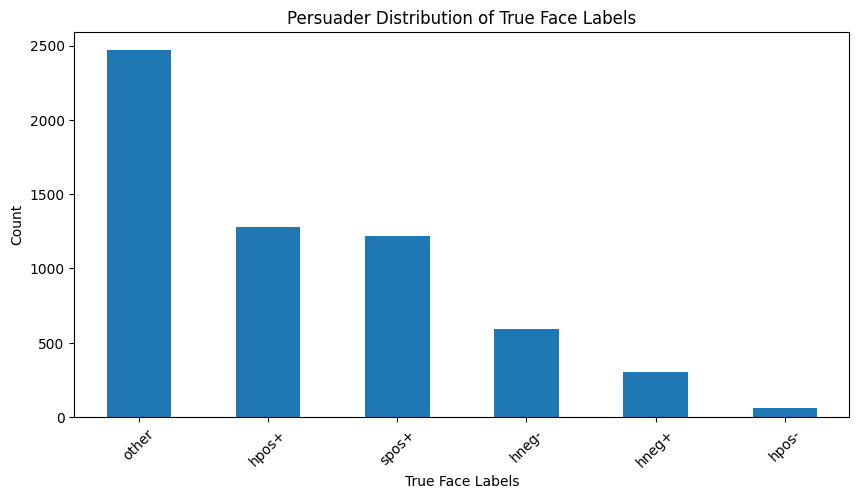

true_face
other    2468
hpos+    1277
spos+    1221
hneg-     593
hneg+     305
hpos-      62
Name: count, dtype: int64


In [19]:
ER_df = pd.DataFrame(ER_formatted_ds)
# Count occurrences of each true_face label
true_face_counts = ER_df['true_face'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
true_face_counts.plot(kind='bar')
plt.title('Persuader Distribution of True Face Labels')
plt.xlabel('True Face Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Get unique values and their counts from the 'true_face' column in ER_ds
true_face_counts = ER_df['true_face'].value_counts()

# Convert the counts to a dictionary if needed
true_face_counts_dict = true_face_counts.to_dict()

# Print the unique values and their counts
print(true_face_counts)  # This will display the counts in descending order

### 3.1 Split the ER dataset into Train, Validation and Test sets

In [20]:
# Shuffle the dataset
ER_ds_shuffled = ER_formatted_ds.shuffle(seed=42)

# Split the dataset into training and testing sets
ER_train_ds, ER_test_ds = ER_formatted_ds.train_test_split(test_size=0.2).values()

# Split the dataset into training and validation sets (80% train, 20% validation)
ER_train_ds, ER_valid_ds = ER_formatted_ds.train_test_split(test_size=0.2).values()

# Display the sizes of the splits
print(f"Train size: {len(ER_train_ds)}, Validation size: {len(ER_valid_ds)}, Test size: {len(ER_test_ds)}")

print(ER_train_ds[0])
print(ER_valid_ds[0])
print(ER_test_ds[0])


Train size: 4740, Validation size: 1186, Test size: 1186
{'speaker': 'ER', 'dialogue': 'very well thanks', 'true_face_id': 4, 'true_face': 'other'}
{'speaker': 'ER', 'dialogue': 'thats why it does make such a difference to even do small things', 'true_face_id': 0, 'true_face': 'hneg+'}
{'speaker': 'ER', 'dialogue': 'it can be any amount from just 010 to the full payment', 'true_face_id': 4, 'true_face': 'other'}


Now we need to assemble the training data. We need to create parallel lists of normalized content.

In [21]:
ER_train_tags = []
ER_train_labels = []
ER_train_texts = []

# Iterate over the formatted dataset
for item in ER_train_ds:
    ER_train_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    ER_train_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    ER_train_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of training samples: {len(ER_train_texts)}")
print(f"Number of training labels: {len(ER_train_labels)}")
print(f"Number of training tags: {len(ER_train_tags)}")

# Print the extracted lists (optional)
print(ER_train_texts[:15])
print(ER_train_tags[:15])  # Print first 5 elements for verification
print(ER_train_labels[:15])  # Print first 5 elements for verification

# Assuming ER_train_labels contains your training labels
class_labels = np.unique(ER_train_labels)
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=ER_train_labels)

# Convert class weights to a dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_labels))}


Number of training samples: 4740
Number of training labels: 4740
Number of training tags: 4740
['very well thanks', 'you know 30 cents may not seem like a lot to you but to a child who is hungry and sick it can mean the difference between life and death', 'hello have you heard of the save a children charity', 'they promote childrens rights and provide much needed relief', 'i am well it looks nice here today as well', 'a cause that you believe in', 'you are donating money you dont even have yet so it is not like you are missing something', 'thats wonderful', 'wish that we could but like all working on mturk we are poor ourselves', 'you can visit url or i can probably arrange to have information mailed to you', 'at all', 'a review of the tax exempt paperwork and financial statements which are available for all tax exempt organizations can help you weed out good from bad', 'there are a few for sure', 'not to mention where are you getting your information', 'when crisis strikes they are al

In [22]:
ER_test_tags = []
ER_test_labels = []
ER_test_texts = []

# Iterate over the formatted dataset
for item in ER_test_ds:
    ER_test_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    ER_test_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    ER_test_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of test samples: {len(ER_test_texts)}")
print(f"Number of test labels: {len(ER_test_labels)}")
print(f"Number of test tags: {len(ER_test_tags)}")

# Print the extracted lists (optional)
print(ER_test_texts[:5])
print(ER_test_tags[:5])  # Print first 5 elements for verification
print(ER_test_labels[:5])  # Print first 5 elements for verification

Number of test samples: 1186
Number of test labels: 1186
Number of test tags: 1186
['it can be any amount from just 010 to the full payment', 'would you like to donate and save the children', 'for example in the first two months of 2018 a thousand children in syria were injured in the violence there', 'i understand it may not seem like a lot but it can really make a difference', 'its always warm here']
['other', 'hneg-', 'other', 'hneg+', 'other']
[4, 1, 4, 0, 4]


We already have a set aside test set and a train set.  Let's explicitly set aside part of our training set for validation purposes.

In [23]:
ER_valid_tags = []
ER_valid_labels = []
ER_valid_texts = []

# Iterate over the formatted dataset
for item in ER_valid_ds:
    ER_valid_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    ER_valid_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    ER_valid_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of validation samples: {len(ER_valid_texts)}")
print(f"Number of validation labels: {len(ER_valid_labels)}")
print(f"Number of validation tags: {len(ER_valid_tags)}")

# Print the extracted lists (optional)
print(ER_valid_texts[:5])
print(ER_valid_tags[:5])  # Print first 5 elements for verification
print(ER_valid_labels[:5])  # Print first 5 elements for verification

Number of validation samples: 1186
Number of validation labels: 1186
Number of validation tags: 1186
['thats why it does make such a difference to even do small things', 'would you be willing to donate', 'i am good', 'i know and im not really sure if they would deduct any real money', 'thank you for your kind donation']
['hneg+', 'hneg-', 'other', 'other', 'hpos+']
[0, 1, 4, 4, 2]


In [24]:
def sort_dict_by_values(input_dict):

    # Create separate sorted lists of the integer tags and the associated labels
    # We'll need this for doing analysis of the results of our classifier

    items = list(input_dict.items())

    items.sort(key=lambda item: int(item[1]))  # Convert values to integers for sorting

    sorted_values = [item[1] for item in items]
    sorted_keys = [item[0] for item in items]

    return sorted_values, sorted_keys  # Return as a tuple

# Use the provided sorting function
sorted_values, sorted_keys = sort_dict_by_values(true_face_to_id)

# Display the results
print("Sorted True Face IDs:", sorted_values)
print("Sorted True Faces:", sorted_keys)
# The variable ''target_names'' stores all of the names of the labels.
target_names = sorted_keys
print(target_names)

Sorted True Face IDs: [0, 1, 2, 3, 4, 5]
Sorted True Faces: ['hneg+', 'hneg-', 'hpos+', 'hpos-', 'other', 'spos+']
['hneg+', 'hneg-', 'hpos+', 'hpos-', 'other', 'spos+']


Here are the variables we've already defined for the data:

* train_texts - an array of text strings for training
* test_texts - an array of text strings for testing
* valid texts - an array of text strings for validation
* train_labels - an array of integers representing the labels associated with train_texts
* test_labels - an array of integers representing the labels associated with test_texts
* valid_labels - an array of integers representing the labels associated with valid_texts
* target_names - an array of label strings that correspond to the integers in the *_labels arrays

### 4. Classification with a fine tuned BERT model

Let's pick our BERT model.  We'll start with the base BERT model and we'll use the cased version since our data has capital and lower case letters.

In [25]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

In [26]:
# Load the DeBERTa v2 tokenizer and model directly from the specified checkpoint
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

We're setting our maximum training record length to 200.  

In [27]:
max_length = 200

Now we'll tokenize our three data slices.  This will take a minute or two.

In [28]:
ER_train_texts[:2]
# Check the type of elements in train_texts
print(type(ER_train_texts[0]))

<class 'str'>


In [29]:
# If train_texts contains elements that are not strings, convert them to strings.
# For example, if train_texts contains integers, use:
ER_train_texts = [str(text) for text in ER_train_texts]
ER_valid_texts = [str(text) for text in ER_valid_texts]
ER_test_texts = [str(text) for text in ER_test_texts]


In [30]:
# tokenize the dataset, truncate at `max_length`,
# Tokenize the datasets
ER_train_encodings = bert_tokenizer(
    ER_train_texts,
    truncation=True,
    padding='max_length',  # Ensure all are padded to max_length
    max_length=200,
    return_tensors='tf'
)
ER_valid_encodings = bert_tokenizer(
    ER_valid_texts,
    truncation=True,
    padding='max_length',
    max_length=200,
    return_tensors='tf'
)
ER_test_encodings = bert_tokenizer(
    ER_test_texts,
    truncation=True,
    padding='max_length',
    max_length=200,
    return_tensors='tf'
)

# Print shapes to verify
print(f"Train input_ids shape: {ER_train_encodings['input_ids'].shape}")
print(f"Validation input_ids shape: {ER_valid_encodings['input_ids'].shape}")
print(f"Test input_ids shape: {ER_test_encodings['input_ids'].shape}")


Train input_ids shape: (4740, 200)
Validation input_ids shape: (1186, 200)
Test input_ids shape: (1186, 200)


Notice our input_ids for the first training record and their padding. The train_encodings also includes an array of token_type_ids and an attention_mask array.

In [31]:
ER_train_encodings

{'input_ids': <tf.Tensor: shape=(4740, 200), dtype=int32, numpy=
array([[  101,  1304,  1218, ...,     0,     0,     0],
       [  101,  1128,  1221, ...,     0,     0,     0],
       [  101, 19082,  1138, ...,     0,     0,     0],
       ...,
       [  101,   189,  6131, ...,     0,     0,     0],
       [  101,  1921,   178, ...,     0,     0,     0],
       [  101,   178,  1267, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(4740, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4740, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [32]:
ER_train_encodings.input_ids[15]

<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([ 101, 3277, 1103, 1482, 6618, 1482, 1155, 1213, 1103, 1362, 1105,
       1152, 1444, 1240, 1494,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### 4.1 Create a Model




In [33]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00006):
    """
    Build a multiclass classification model using BERT with a custom hidden layer.

    Arguments:
    - checkpoint: The pre-trained BERT model checkpoint.
    - num_classes: Number of output classes for classification.
    - hidden_size: Size of the hidden layer.
    - dropout: Dropout rate for regularization.
    - learning_rate: Learning rate for optimization.

    Returns:
    - A compiled TensorFlow Keras model ready for training.
    """
    # Define the input layers for token IDs, attention masks, and segment IDs
    input_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name='token_type_ids')  # Added token_type_ids

    # Pass the inputs through the BERT model
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Use the pooler_output for classification (CLS token's embedding)
    pooler_output = bert_outputs.pooler_output

    # Add a hidden dense layer with the specified size
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu')(pooler_output)

    # Apply dropout for regularization
    dropout_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)

    # Classification layer for multi-class output, using softmax activation
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

    # Define the model
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output_layer)

    # Compile the model with SparseCategoricalCrossentropy (for single-label multi-class classification)
    #classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                  #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                  #metrics=['accuracy'])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00006, clipnorm=0.5),  # Adding gradient clipping
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    return classification_model

In [34]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=6)

In [35]:
pooler_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                              

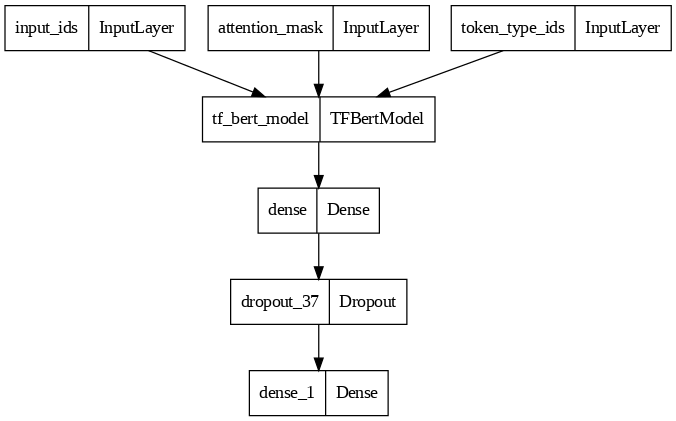

In [36]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [37]:
print("Unique labels in training set:", np.unique(ER_train_labels))
print("Unique labels in validation set:", np.unique(ER_valid_labels))

Unique labels in training set: [0 1 2 3 4 5]
Unique labels in validation set: [0 1 2 3 4 5]


### 4.2 Train the base Model

In [38]:
# Convert train_labels and val_labels to NumPy arrays if they are not already
ER_train_labels = np.array(ER_train_labels, dtype=np.int32)
ER_valid_labels = np.array(ER_valid_labels, dtype=np.int32)

pooler_bert_model_history = pooler_bert_model.fit([ER_train_encodings.input_ids, ER_train_encodings.token_type_ids, ER_train_encodings.attention_mask],
                                                  ER_train_labels,
                                                  validation_data=([ER_valid_encodings.input_ids, ER_valid_encodings.token_type_ids, ER_valid_encodings.attention_mask],
                                                  ER_valid_labels),
                                                  batch_size=8,
                                                  epochs=1)

593/593 [==============================] - 316s 411ms/step - loss: 1.1234 - accuracy: 0.5726 - val_loss: 0.9731 - val_accuracy: 0.6324


### 4.3 Class Weights to Mitigate Class Imbalance

In [39]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ER_train_labels),
    y=ER_train_labels
)

# Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Fit the model with class weights
pooler_bert_model_history = pooler_bert_model.fit(
    [ER_train_encodings.input_ids, ER_train_encodings.token_type_ids, ER_train_encodings.attention_mask],
    ER_train_labels,
    validation_data=(
        [ER_valid_encodings.input_ids, ER_valid_encodings.token_type_ids, ER_valid_encodings.attention_mask],
        ER_valid_labels
    ),
    batch_size=32,
    epochs=5,
    class_weight=class_weight_dict  # Include class weights here
)

Epoch 1/5
149/149 [==============================] - 229s 1s/step - loss: 1.0919 - accuracy: 0.7456 - val_loss: 1.0065 - val_accuracy: 0.6551
Epoch 2/5
149/149 [==============================] - 208s 1s/step - loss: 0.8244 - accuracy: 0.7838 - val_loss: 0.9069 - val_accuracy: 0.6821
Epoch 3/5
149/149 [==============================] - 208s 1s/step - loss: 0.5836 - accuracy: 0.8302 - val_loss: 1.0739 - val_accuracy: 0.6771
Epoch 4/5
149/149 [==============================] - 208s 1s/step - loss: 0.3446 - accuracy: 0.8646 - val_loss: 1.0889 - val_accuracy: 0.6939
Epoch 5/5
149/149 [==============================] - 208s 1s/step - loss: 0.2504 - accuracy: 0.9004 - val_loss: 1.1647 - val_accuracy: 0.6906


Now we need to run evaluate against our fine-tuned model.  This will give us an overall accuracy based on the test set.

### 4.4 Evaluate the model on the ER Test set

In [40]:
ER_test_labels = np.array(ER_test_labels)
# Evaluate the model
score = pooler_bert_model.evaluate([ER_test_encodings.input_ids, ER_test_encodings.token_type_ids, ER_test_encodings.attention_mask],
                                                  ER_test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

38/38 [==============================] - 25s 410ms/step - loss: 0.4128 - accuracy: 0.8777
Test loss: 0.41276657581329346
Test accuracy: 0.8777403235435486


In [41]:
#run predict for the first three elements in the test data set
predictions = pooler_bert_model.predict([
    ER_test_encodings.input_ids,
    ER_test_encodings.token_type_ids,
    ER_test_encodings.attention_mask
])


38/38 [==============================] - 25s 412ms/step


### 4.5 Generate the classification Report

In [42]:
print("Predictions shape:", predictions.shape)
# we need to get the highest probability in the distribution for each prediction
predicted_classes = tf.argmax(predictions, axis=-1)

# Convert predicted_classes to a NumPy array
predicted_classes = predicted_classes.numpy()

# Generate the classification report
print(classification_report(ER_test_labels, predicted_classes, target_names=target_names))

Predictions shape: (1186, 6)
              precision    recall  f1-score   support

       hneg+       0.67      0.88      0.76        69
       hneg-       0.88      0.95      0.91       128
       hpos+       0.88      0.92      0.90       250
       hpos-       0.76      0.84      0.80        19
       other       0.94      0.81      0.87       497
       spos+       0.85      0.94      0.89       223

    accuracy                           0.88      1186
   macro avg       0.83      0.89      0.86      1186
weighted avg       0.89      0.88      0.88      1186



In [43]:
cm = tf.math.confusion_matrix(ER_test_labels, predicted_classes)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

And now we'll display it!

### 4.6 Plot a confusion Matrix

Text(220.72222222222223, 0.5, 'True')

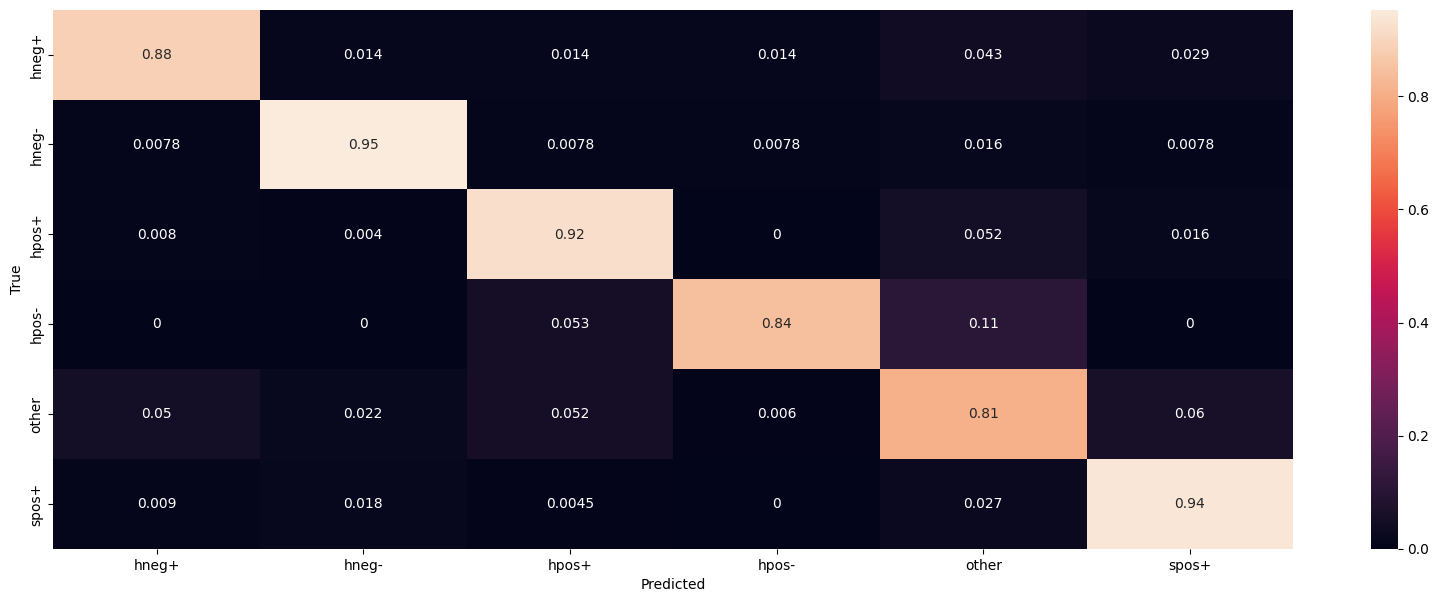

In [44]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### 5. Format the EE Dataset

In [45]:
# Function to clean dialogue
def clean_dialogue(dialogue):
    if isinstance(dialogue, str):  # Ensure the input is a string
        # Lowercase
        dialogue = dialogue.lower()
        # Remove punctuation
        dialogue = re.sub(r'[^\w\s]', '', dialogue)
        # Strip whitespace
        dialogue = dialogue.strip()
        return dialogue
    else:
        return ""  # Return an empty string or handle as you prefer

cleaned_data = []
EE_formatted_ds = []
true_face_labels = set()  # To collect unique true_face labels

# Use iterrows() to iterate through the DataFrame
for index, row in EE_dataset.iterrows():
    speaker = row['speaker']
    utterance = row['utterance']
    true_face = row['true_face']

    # Clean the utterance
    cleaned_utterance = clean_dialogue(utterance)

    # Collect unique true_face labels
    true_face_labels.add(true_face)

    # Append the speaker and cleaned utterance to the formatted data
    EE_formatted_ds.append({
        'speaker': f"{speaker}",
        'dialogue': cleaned_utterance,  # Store cleaned dialogue
        'true_face': true_face  # Keep original true_face for now
    })

# Create a mapping from true_face labels to IDs
sorted_labels = sorted(label for label in true_face_labels)

# Create a mapping from sorted labels to IDs
true_face_to_id = {label: idx for idx, label in enumerate(sorted_labels)}

# Create a new Dataset from the formatted data and convert labels to IDs
EE_formatted_ds = Dataset.from_dict({
    'speaker': [entry['speaker'] for entry in EE_formatted_ds],
    'dialogue': [entry['dialogue'] for entry in EE_formatted_ds],
    'true_face_id': [true_face_to_id[entry['true_face']] for entry in EE_formatted_ds],  # Converts true_face to ID
    'true_face': [entry['true_face'] for entry in EE_formatted_ds]  # Keeps the original true_face
})

# Display first 100 entries of the formatted dataset
print(EE_formatted_ds[:5])
# Print the mapping of true_face labels to IDs
print(true_face_to_id)

{'speaker': ['EE', 'EE', 'EE', 'EE', 'EE'], 'dialogue': ['i think i have once before in a grocery store i believe', 'sure go ahead', 'are they a non profit organization', 'oh wow shocking news', 'do you know how many children have been helped due to this organization'], 'true_face_id': [1, 1, 0, 1, 0], 'true_face': ['hpos+', 'hpos+', 'hneg-', 'hpos+', 'hneg-']}
{'hneg-': 0, 'hpos+': 1, 'hpos-': 2, 'other': 3, 'sneg+': 4, 'spos+': 5, 'spos-': 6}


### 5.1 Explore the EE Dataset

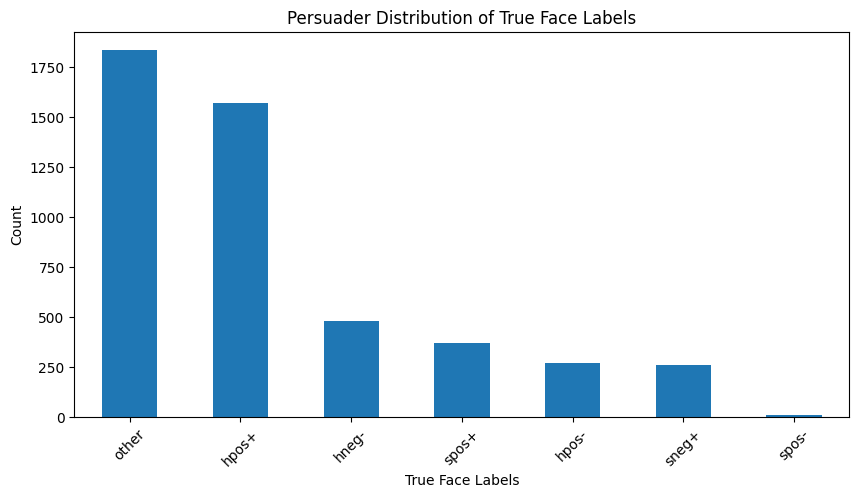

true_face
other    1832
hpos+    1567
hneg-     480
spos+     368
hpos-     272
sneg+     259
spos-      12
Name: count, dtype: int64


In [46]:
EE_df = pd.DataFrame(EE_formatted_ds)
# Count occurrences of each true_face label
true_face_counts = EE_df['true_face'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 5))
true_face_counts.plot(kind='bar')
plt.title('Persuader Distribution of True Face Labels')
plt.xlabel('True Face Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Get unique values and their counts from the 'true_face' column in ER_ds
true_face_counts = EE_df['true_face'].value_counts()

# Convert the counts to a dictionary if needed
true_face_counts_dict = true_face_counts.to_dict()

# Print the unique values and their counts
print(true_face_counts)  # This will display the counts in descending order

### 5.2 Split the EE Dataset into Train, Validation and Test datasets

In [47]:
# Shuffle the dataset
EE_ds_shuffled = EE_formatted_ds.shuffle(seed=42)

# Split the dataset into training and testing sets
EE_train_ds, EE_test_ds = EE_formatted_ds.train_test_split(test_size=0.2).values()

# Split the dataset into training and validation sets (80% train, 20% validation)
EE_train_ds, EE_valid_ds = EE_formatted_ds.train_test_split(test_size=0.2).values()

# Display the sizes of the splits
print(f"Train size: {len(EE_train_ds)}, Validation size: {len(EE_valid_ds)}, Test size: {len(EE_test_ds)}")

print(EE_train_ds[0])
print(EE_valid_ds[0])
print(EE_test_ds[0])

Train size: 3832, Validation size: 958, Test size: 958
{'speaker': 'EE', 'dialogue': 'i think i will donate one cent', 'true_face_id': 1, 'true_face': 'hpos+'}
{'speaker': 'EE', 'dialogue': 'haha', 'true_face_id': 3, 'true_face': 'other'}
{'speaker': 'EE', 'dialogue': 'wow that definitely puts it in perspective', 'true_face_id': 1, 'true_face': 'hpos+'}


### 6.1 Generate Text, Tag and Labels from the Datasets

In [48]:
EE_train_tags = []
EE_train_labels = []
EE_train_texts = []

# Iterate over the formatted dataset
for item in EE_train_ds:
    EE_train_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    EE_train_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    EE_train_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of training samples: {len(EE_train_texts)}")
print(f"Number of training labels: {len(EE_train_labels)}")
print(f"Number of training tags: {len(EE_train_tags)}")

# Print the extracted lists (optional)
print(EE_train_texts[:15])
print(EE_train_tags[:15])  # Print first 5 elements for verification
print(EE_train_labels[:15])  # Print first 5 elements for verification

Number of training samples: 3832
Number of training labels: 3832
Number of training tags: 3832
['i think i will donate one cent', 'i have considered donating to st jude also because they provide life saving medical care', 'i would', 'could i pledge 1day to start with', 'yes i have', 'what do you like most about this group', 'no problem thank you for telling me about this wonderful charity', 'children should be our top priority all across the world', 'i would do anything to protect my son', 'i am so sorry to hear about the little guy and how his birthday too', 'how much do they recommend you donate', 'are you planning to donate today', 'do you make donations on line or mail it in', 'mmmm that is interesting i did not know that statistic', 'i recognize it too']
['hpos+', 'other', 'hpos+', 'hpos+', 'hpos+', 'other', 'hpos+', 'other', 'other', 'hpos+', 'other', 'other', 'hneg-', 'other', 'hpos+']
[1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1]


In [49]:
EE_test_tags = []
EE_test_labels = []
EE_test_texts = []

# Iterate over the formatted dataset
for item in EE_test_ds:
    EE_test_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    EE_test_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    EE_test_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of training samples: {len(EE_test_texts)}")
print(f"Number of training labels: {len(EE_test_labels)}")
print(f"Number of training tags: {len(EE_test_tags)}")

# Print the extracted lists (optional)
print(EE_test_texts[:15])
print(EE_test_tags[:15])  # Print first 5 elements for verification
print(EE_test_labels[:15])  # Print first 5 elements for verification



Number of training samples: 958
Number of training labels: 958
Number of training tags: 958
['wow that definitely puts it in perspective', 'its the reason i go to work everyday', 'oh thats totally awesome', 'i wouldnt have the time off to do that', 'do i need to do anything else to make sure i get the money donated', 'i will have to read up more about the organization before i just give my money up because there is fake charities in the world', 'what sort of assistance do they offer specifically', 'cant complain youreslf', 'where does the other percentage of donations go', 'it is sad i agree with you', 'id donate more but i dont have much myself', 'how has save the children helped to aid in health education and safety of the syrian children', 'do you have kids', 'why is that', 'i have been to third world countries in south america and seeing the living conditions of some people is very tough']
['hpos+', 'spos+', 'hpos+', 'other', 'other', 'sneg+', 'hneg-', 'other', 'hneg-', 'hpos+', 's

In [50]:
EE_valid_tags = []
EE_valid_labels = []
EE_valid_texts = []

# Iterate over the formatted dataset
for item in EE_valid_ds:
    EE_valid_texts.append(item['dialogue'])  # Add the cleaned dialogue to train_text
    EE_valid_labels.append(item['true_face_id'])  # Add the true_face ID to train_labels
    EE_valid_tags.append(item['true_face'])  # Add the original true_face to train_tags (optional)

# Print out the sizes of the lists
print(f"Number of training samples: {len(EE_valid_texts)}")
print(f"Number of training labels: {len(EE_valid_labels)}")
print(f"Number of training tags: {len(EE_valid_tags)}")

# Print the extracted lists (optional)
print(EE_valid_texts[:15])
print(EE_valid_tags[:15])  # Print first 5 elements for verification
print(EE_valid_labels[:15])  # Print first 5 elements for verification

Number of training samples: 958
Number of training labels: 958
Number of training tags: 958
['haha', 'if only the governments and politicians of the world would stop fighting and actually work toward that goal', 'we have to walk early and late', 'good choice', 'yeah  all good things', 'oh wow i would also be interested in donating to that', 'i do not', 'i am all for helping children in any way possible', 'ok  so can i donate 20', 'i havent is that a charity', 'ok will check it out', 'maybe 050', 'yeah i agree', 'i agree its for a good cause', 'wow that is neat']
['other', 'other', 'other', 'other', 'hpos+', 'spos+', 'other', 'spos+', 'hpos+', 'hpos-', 'other', 'hpos+', 'hpos+', 'hpos+', 'hpos+']
[3, 3, 3, 3, 1, 5, 3, 5, 1, 2, 3, 1, 1, 1, 1]


In [51]:
def sort_dict_by_values(input_dict):

    # Create separate sorted lists of the integer tags and the associated labels
    # We'll need this for doing analysis of the results of our classifier

    items = list(input_dict.items())

    items.sort(key=lambda item: int(item[1]))  # Convert values to integers for sorting

    sorted_values = [item[1] for item in items]
    sorted_keys = [item[0] for item in items]

    return sorted_values, sorted_keys  # Return as a tuple

# Use the provided sorting function
sorted_values, sorted_keys = sort_dict_by_values(true_face_to_id)

# Display the results
print("Sorted True Face IDs:", sorted_values)
print("Sorted True Faces:", sorted_keys)
# The variable ''target_names'' stores all of the names of the labels.
target_names = sorted_keys
print(target_names)

Sorted True Face IDs: [0, 1, 2, 3, 4, 5, 6]
Sorted True Faces: ['hneg-', 'hpos+', 'hpos-', 'other', 'sneg+', 'spos+', 'spos-']
['hneg-', 'hpos+', 'hpos-', 'other', 'sneg+', 'spos+', 'spos-']


In [52]:
EE_train_texts[:2]
# Check the type of elements in train_texts
print(type(EE_train_texts[0]))

<class 'str'>


In [53]:
# If train_texts contains elements that are not strings, convert them to strings.
# For example, if train_texts contains integers, use:
EE_train_texts = [str(text) for text in EE_train_texts]
EE_valid_texts = [str(text) for text in EE_valid_texts]
EE_test_texts = [str(text) for text in EE_test_texts]

### 6.2 Tokenize and Prepare Text Data for BERT Model Training

In [54]:
# tokenize the dataset, truncate at `max_length`,
# Tokenize the datasets
EE_train_encodings = bert_tokenizer(
    EE_train_texts,
    truncation=True,
    padding='max_length',  # Ensure all are padded to max_length
    max_length=200,
    return_tensors='tf'
)
EE_valid_encodings = bert_tokenizer(
    EE_valid_texts,
    truncation=True,
    padding='max_length',
    max_length=200,
    return_tensors='tf'
)
EE_test_encodings = bert_tokenizer(
    EE_test_texts,
    truncation=True,
    padding='max_length',
    max_length=200,
    return_tensors='tf'
)

# Print shapes to verify
print(f"Train input_ids shape: {EE_train_encodings['input_ids'].shape}")
print(f"Validation input_ids shape: {EE_valid_encodings['input_ids'].shape}")
print(f"Test input_ids shape: {EE_test_encodings['input_ids'].shape}")

Train input_ids shape: (3832, 200)
Validation input_ids shape: (958, 200)
Test input_ids shape: (958, 200)


In [57]:
EE_train_encodings

{'input_ids': <tf.Tensor: shape=(3832, 200), dtype=int32, numpy=
array([[ 101,  178, 1341, ...,    0,    0,    0],
       [ 101,  178, 1138, ...,    0,    0,    0],
       [ 101,  178, 1156, ...,    0,    0,    0],
       ...,
       [ 101, 1103, 6307, ...,    0,    0,    0],
       [ 101, 1175, 1132, ...,    0,    0,    0],
       [ 101,  178, 1138, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(3832, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3832, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [58]:
EE_train_encodings.input_ids[15]

<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([ 101, 9294, 2317, 1198, 1867, 1482, 1116, 6630, 1133, 1674, 1136,
       4734, 1251, 2747, 1116,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### 7 Train the Base model

In [61]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=7)

In [60]:
print("Unique labels in training set:", np.unique(EE_train_labels))
print("Unique labels in validation set:", np.unique(EE_valid_labels))
print("Unique labels in validation set:", np.unique(EE_test_labels))

Unique labels in training set: [0 1 2 3 4 5 6]
Unique labels in validation set: [0 1 2 3 4 5 6]
Unique labels in validation set: [0 1 2 3 4 5 6]


In [62]:
pooler_bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                            

In [63]:
# Convert train_labels and val_labels to NumPy arrays if they are not already
EE_train_labels = np.array(EE_train_labels, dtype=np.int32)
EE_valid_labels = np.array(EE_valid_labels, dtype=np.int32)

pooler_bert_EE_model_history = pooler_bert_model.fit([EE_train_encodings.input_ids, EE_train_encodings.token_type_ids, EE_train_encodings.attention_mask],
                                                  EE_train_labels,
                                                  validation_data=([EE_valid_encodings.input_ids, EE_valid_encodings.token_type_ids, EE_valid_encodings.attention_mask],
                                                  EE_valid_labels),
                                                  batch_size=8,
                                                  epochs=1)

479/479 [==============================] - 248s 404ms/step - loss: 1.2107 - accuracy: 0.5412 - val_loss: 1.0805 - val_accuracy: 0.6002


### 7.1 Class Weights to Mitigate Class Imbalance

In [64]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(EE_train_labels),
    y=EE_train_labels
)

# Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Fit the model with class weights
pooler_bert_EE_model_history = pooler_bert_model.fit(
    [EE_train_encodings.input_ids, EE_train_encodings.token_type_ids, EE_train_encodings.attention_mask],
    EE_train_labels,
    validation_data=(
        [EE_valid_encodings.input_ids, EE_valid_encodings.token_type_ids, EE_valid_encodings.attention_mask],
        EE_valid_labels
    ),
    batch_size=32,
    epochs=5,
    class_weight=class_weight_dict  # Include class weights here
)

Epoch 1/5
120/120 [==============================] - 203s 1s/step - loss: 1.3371 - accuracy: 0.6587 - val_loss: 1.2807 - val_accuracy: 0.5522
Epoch 2/5
120/120 [==============================] - 172s 1s/step - loss: 1.0175 - accuracy: 0.7390 - val_loss: 1.2931 - val_accuracy: 0.5710
Epoch 3/5
120/120 [==============================] - 172s 1s/step - loss: 0.6410 - accuracy: 0.8066 - val_loss: 1.2611 - val_accuracy: 0.5919
Epoch 4/5
120/120 [==============================] - 172s 1s/step - loss: 0.3365 - accuracy: 0.8377 - val_loss: 1.4748 - val_accuracy: 0.6086
Epoch 5/5
120/120 [==============================] - 164s 1s/step - loss: 0.2224 - accuracy: 0.8789 - val_loss: 1.5484 - val_accuracy: 0.6127


### 7.2 Evaluate the model on the EE Test set

In [65]:
EE_test_labels = np.array(EE_test_labels)
# Evaluate the model
score = pooler_bert_model.evaluate([EE_test_encodings.input_ids, EE_test_encodings.token_type_ids, EE_test_encodings.attention_mask],
                                                  EE_test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 22s 414ms/step - loss: 0.5308 - accuracy: 0.8549
Test loss: 0.5308212041854858
Test accuracy: 0.8549060821533203


In [66]:
#run predict for the first three elements in the test data set
predictions = pooler_bert_model.predict([
    EE_test_encodings.input_ids,
    EE_test_encodings.token_type_ids,
    EE_test_encodings.attention_mask
])

30/30 [==============================] - 22s 413ms/step


### 8. Generate Classification Report

In [67]:
print("Predictions shape:", predictions.shape)
# we need to get the highest probability in the distribution for each prediction
predicted_classes = tf.argmax(predictions, axis=-1)

# Convert predicted_classes to a NumPy array
predicted_classes = predicted_classes.numpy()

# Generate the classification report
print(classification_report(EE_test_labels, predicted_classes, target_names=target_names))

Predictions shape: (958, 7)
              precision    recall  f1-score   support

       hneg-       0.70      0.95      0.80        75
       hpos+       0.85      0.93      0.89       312
       hpos-       0.86      0.88      0.87        69
       other       0.94      0.77      0.84       375
       sneg+       0.78      0.92      0.84        53
       spos+       0.80      0.83      0.81        71
       spos-       0.75      1.00      0.86         3

    accuracy                           0.85       958
   macro avg       0.81      0.90      0.85       958
weighted avg       0.87      0.85      0.85       958



### 8.1 Display Confusion Matrix

Text(220.72222222222223, 0.5, 'True')

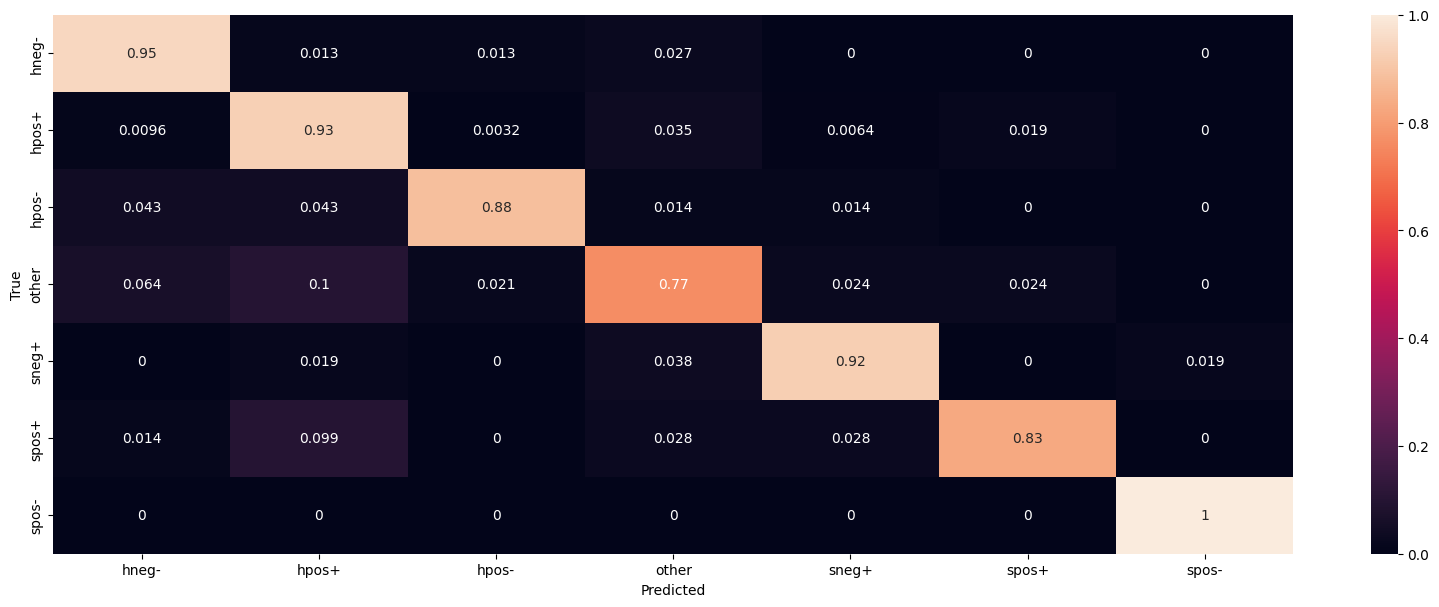

In [69]:
cm = tf.math.confusion_matrix(EE_test_labels, predicted_classes)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]


plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")